# 1. Transfer learning

## a. Download and unzip the dataset

In [1]:
import urllib.request, zipfile
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
urllib.request.urlretrieve(url, 'hymenoptera_data.zip')
with zipfile.ZipFile('hymenoptera_data.zip', 'r') as z:
    z.extractall('.')

## b. Create datasets with ImageFolder
## c. Define train/test transforms

In [23]:
import torchvision  
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

train_dir = './hymenoptera_data/train'
val_dir   = './hymenoptera_data/val'

In [24]:
import torch
from torch.utils.data import DataLoader
from PIL import Image      

# compute mean and std on training data
stat_transform = transforms.Compose([
    transforms.ToTensor(),  # convert to [0,1] tensor
])
stat_dataset = datasets.ImageFolder(train_dir, transform=stat_transform)
stat_loader  = DataLoader(stat_dataset, batch_size=64, shuffle=False, num_workers=0)

sum_rgb, sum_sq_rgb = torch.zeros(3), torch.zeros(3)
num_pixels = 0

for img_path, _ in stat_dataset.samples:
    img = Image.open(img_path).convert('RGB')        
    tensor = transforms.ToTensor()(img)              # to [0,1] tensor
    C, H, W = tensor.shape
    n = H * W
    sum_rgb    += tensor.sum(dim=[1,2])
    sum_sq_rgb += (tensor**2).sum(dim=[1,2])
    num_pixels += n

mean = sum_rgb / num_pixels
std  = (sum_sq_rgb / num_pixels - mean**2).sqrt()

print('Calculated mean:', mean.tolist())
print('Calculated std: ', std.tolist())

# use computed mean and std for data transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)


Calculated mean: [0.5171595215797424, 0.47527703642845154, 0.34843185544013977]
Calculated std:  [0.2775607407093048, 0.2574646472930908, 0.28648102283477783]


## d. Visualize a batch of training images

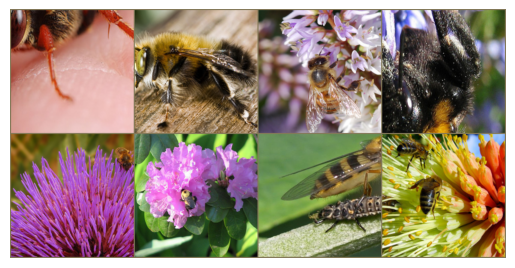

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean_np = np.array(mean)   
std_np  = np.array(std)   

def imshow(inp):
    img = inp.numpy().transpose((1,2,0))
    img = img * std_np + mean_np
    plt.imshow(np.clip(img,0,1))
    plt.axis('off')

inputs, classes = next(iter(train_loader))
grid = torchvision.utils.make_grid(inputs[:8], nrow=4)
imshow(grid)


## e. Load pretrained ResNet-18


In [36]:
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

## f. Calculate number of features from the final fc layer parameters


In [37]:
num_ftrs = model.fc.in_features
print(f'Feature extractor output features: {num_ftrs}')

Feature extractor output features: 512


## g. Replace final fully-connected layer


In [38]:
import torch.nn as nn

model.fc = nn.Linear(num_ftrs, 2)

## h+i. Training loop with SGD+momentum and cosine LR decay
1) Train with fine-tuning all parameters of the pretrained ResNet-18 end-to-end; 
2) Freezing the feature extractor parameters and only train the new last fully-connected layer; 
3) Do experiment number (1) but train from randomly initialized parameters. For each of these experiments, plot the train/test loss/accuracy.

In [39]:
import torch.optim as optim
device = torch.device('cuda:0')

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return total_loss/total, correct/total

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

def run_experiment(model, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()
    stats = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs):
        tl, ta = train_epoch(model, train_loader, criterion, optimizer)
        vl, va = evaluate(model, val_loader,   criterion)
        stats['train_loss'].append(tl)
        stats['train_acc'].append(ta)
        stats['val_loss'].append(vl)
        stats['val_acc'].append(va)
        scheduler.step()
        print(f'Epoch {epoch+1}/{epochs} | '
              f'train_loss={tl:.4f}, train_acc={ta:.4f} | '
              f'val_loss={vl:.4f}, val_acc={va:.4f}')
    return stats


In [40]:
# prepare containers
all_stats = {}

# Experiment 1: fine‑tune all parameters
# model1 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# num_ftrs = model1.fc.in_features
# model1.fc = nn.Linear(num_ftrs, 2)
model1 = model.to(device)
opt1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
sch1 = optim.lr_scheduler.CosineAnnealingLR(opt1, T_max=10)
all_stats['fine_tune'] = run_experiment(model1, opt1, sch1, epochs=10)

# Experiment 2: freeze feature extractor, train only fc
model2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in model2.parameters():
    p.requires_grad = False
model2.fc = nn.Linear(model2.fc.in_features, 2)
model2 = model2.to(device)
opt2 = optim.SGD(model2.fc.parameters(), lr=0.01, momentum=0.9)
sch2 = optim.lr_scheduler.CosineAnnealingLR(opt2, T_max=10)
all_stats['freeze_fc'] = run_experiment(model2, opt2, sch2, epochs=10)

# Experiment 3: train from scratch
model3 = models.resnet18(weights=None)
model3.fc = nn.Linear(model3.fc.in_features, 2)
model3 = model3.to(device)
opt3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
sch3 = optim.lr_scheduler.CosineAnnealingLR(opt3, T_max=10)
all_stats['scratch'] = run_experiment(model3, opt3, sch3, epochs=10)

Epoch 1/10 | train_loss=0.7294, train_acc=0.5287 | val_loss=0.5208, val_acc=0.8235
Epoch 2/10 | train_loss=0.4810, train_acc=0.8033 | val_loss=0.3207, val_acc=0.9281
Epoch 3/10 | train_loss=0.3079, train_acc=0.9139 | val_loss=0.2291, val_acc=0.9412
Epoch 4/10 | train_loss=0.2209, train_acc=0.9549 | val_loss=0.1960, val_acc=0.9412
Epoch 5/10 | train_loss=0.2223, train_acc=0.9180 | val_loss=0.1838, val_acc=0.9477
Epoch 6/10 | train_loss=0.1663, train_acc=0.9590 | val_loss=0.1759, val_acc=0.9412
Epoch 7/10 | train_loss=0.1854, train_acc=0.9426 | val_loss=0.1713, val_acc=0.9412
Epoch 8/10 | train_loss=0.2097, train_acc=0.9180 | val_loss=0.1706, val_acc=0.9477
Epoch 9/10 | train_loss=0.1689, train_acc=0.9344 | val_loss=0.1717, val_acc=0.9477
Epoch 10/10 | train_loss=0.1347, train_acc=0.9672 | val_loss=0.1713, val_acc=0.9477
Epoch 1/10 | train_loss=0.5439, train_acc=0.6885 | val_loss=0.1738, val_acc=0.9673
Epoch 2/10 | train_loss=0.2606, train_acc=0.8975 | val_loss=0.1544, val_acc=0.9608
Epo

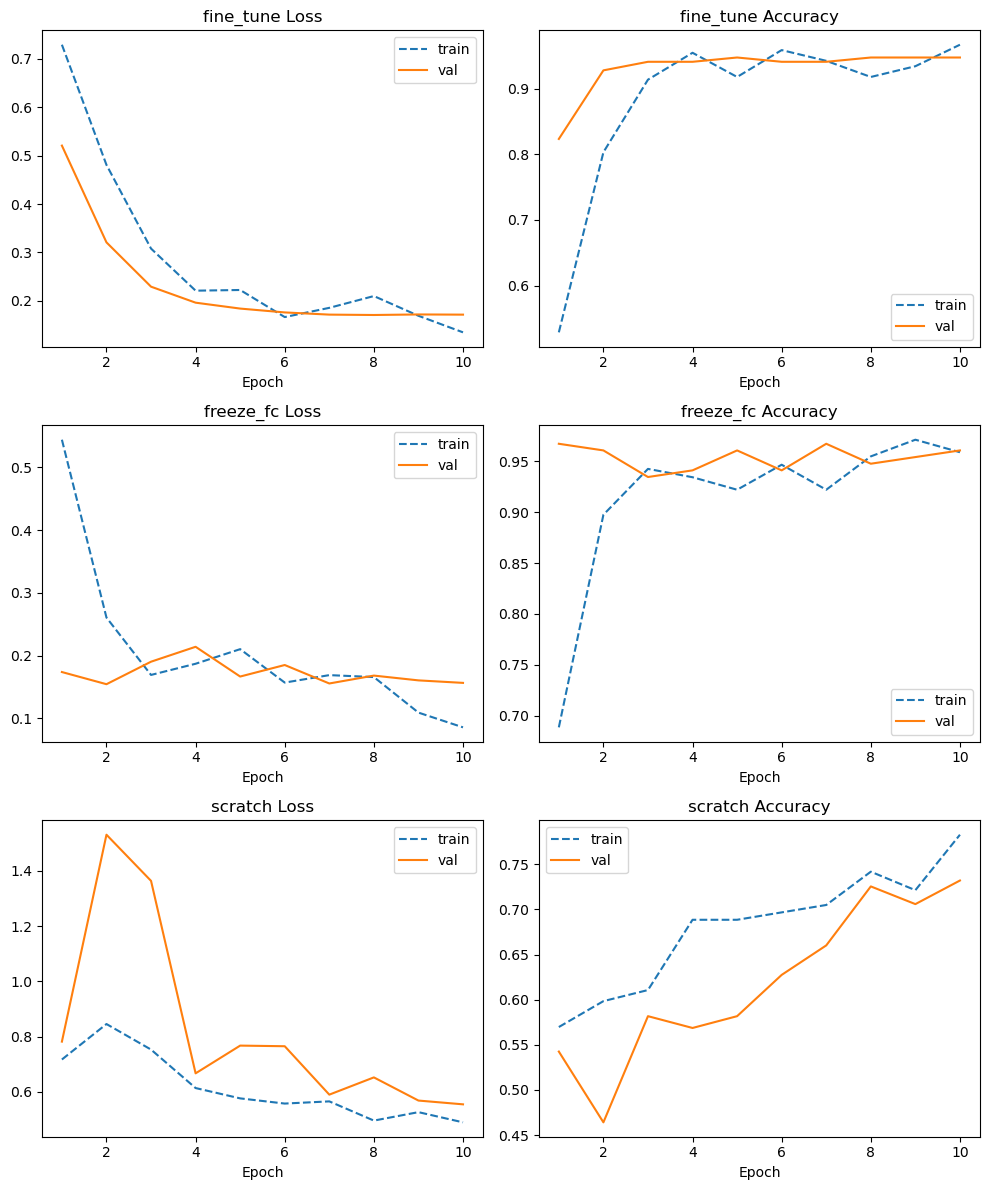

In [ ]:
epochs = range(1, 11)

fig, axes = plt.subplots(len(all_stats), 2, figsize=(10, 12))
for i, (name, stats) in enumerate(all_stats.items()):
    ax_l, ax_a = axes[i]
    # loss
    ax_l.plot(epochs, stats['train_loss'], '--', label='train')
    ax_l.plot(epochs, stats['val_loss'],  '-', label='val')
    ax_l.set_title(f'{name} Loss')
    ax_l.set_xlabel('Epoch')
    ax_l.legend()
    # accuracy
    ax_a.plot(epochs, stats['train_acc'], '--', label='train')
    ax_a.plot(epochs, stats['val_acc'],  '-', label='val')
    ax_a.set_title(f'{name} Accuracy')
    ax_a.set_xlabel('Epoch')
    ax_a.legend()

plt.tight_layout()
plt.show()


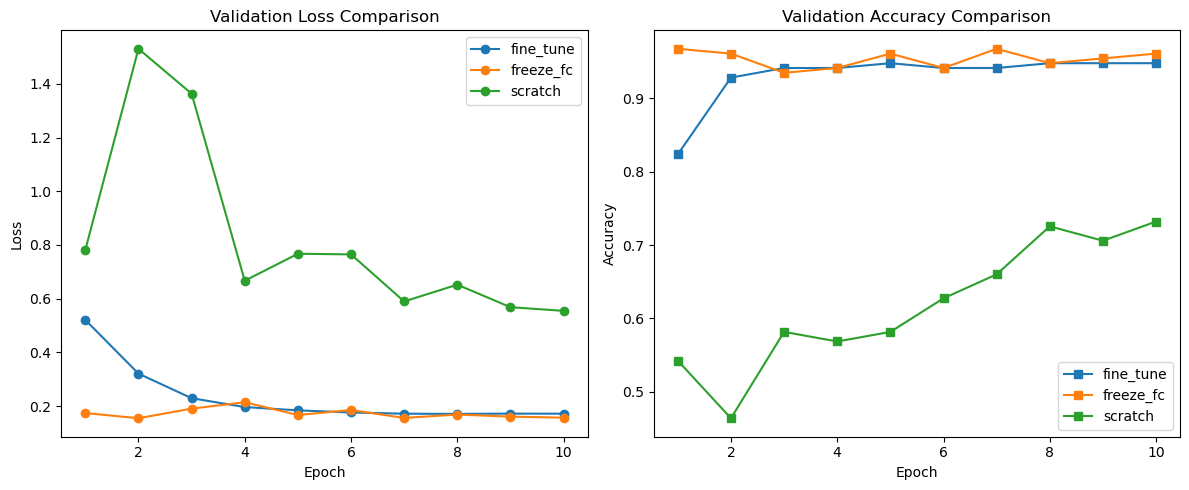

In [43]:
import matplotlib.pyplot as plt

# assume all_stats is a dict with keys: 'fine_tune', 'freeze_fc', 'scratch'
# and values: stats dicts containing 'val_loss' and 'val_acc' lists of length epochs
epochs = range(1, len(next(iter(all_stats.values()))['val_loss']) + 1)

plt.figure(figsize=(12,5))

# Validation Loss comparison
plt.subplot(1, 2, 1)
for name, stats in all_stats.items():
    plt.plot(epochs, stats['val_loss'], marker='o', label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy comparison
plt.subplot(1, 2, 2)
for name, stats in all_stats.items():
    plt.plot(epochs, stats['val_acc'], marker='s', label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## j. Compute the test accuracy for each of these experiments.

In [45]:
# assume model1, model2, model3 are your three trained models
# and val_loader is your “test” loader from above
def test_acc(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    return correct / total

acc1 = test_acc(model1)      # fine‑tune all params
acc2 = test_acc(model2)      # freeze feature extractor
acc3 = test_acc(model3)      # scratch

print(f'Fine‑tune accuracy:   {acc1:.4f}')
print(f'Freeze‑fc accuracy:   {acc2:.4f}')
print(f'Scratch accuracy:     {acc3:.4f}')


Fine‑tune accuracy:   0.9477
Freeze‑fc accuracy:   0.9608
Scratch accuracy:     0.7320


## As we can see from above, the second model performs the best.

# 2. Semantic segmentation 

## a. Let’s first download and build the dataset.

In [ ]:
import os, random, glob
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import functional as TF, Resize, CenterCrop, ToTensor


from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

# 1. Download
data_dir = "./oxford_pet"
os.makedirs(data_dir, exist_ok=True)
SimpleOxfordPetDataset.download(data_dir)

# 2. Compute mean/std on raw images folder
paths = glob.glob(os.path.join(data_dir, "images", "*.jpg"))
sum_c, sum_sq, n_pix = torch.zeros(3), torch.zeros(3), 0
for p in paths:
    img = Image.open(p).convert("RGB")
    img = Resize(256)(img)
    img = CenterCrop(224)(img)
    t   = ToTensor()(img)
    sum_c  += t.sum(dim=[1,2])
    sum_sq += (t**2).sum(dim=[1,2])
    n_pix  += t.shape[1]*t.shape[2]
mean = (sum_c / n_pix).tolist()
std  = torch.sqrt(sum_sq/n_pix - torch.tensor(mean)**2).tolist()

print(mean,std)


[0.4863832890987396, 0.4483054280281067, 0.3962746262550354] [0.2611962556838989, 0.25569626688957214, 0.26229962706565857]


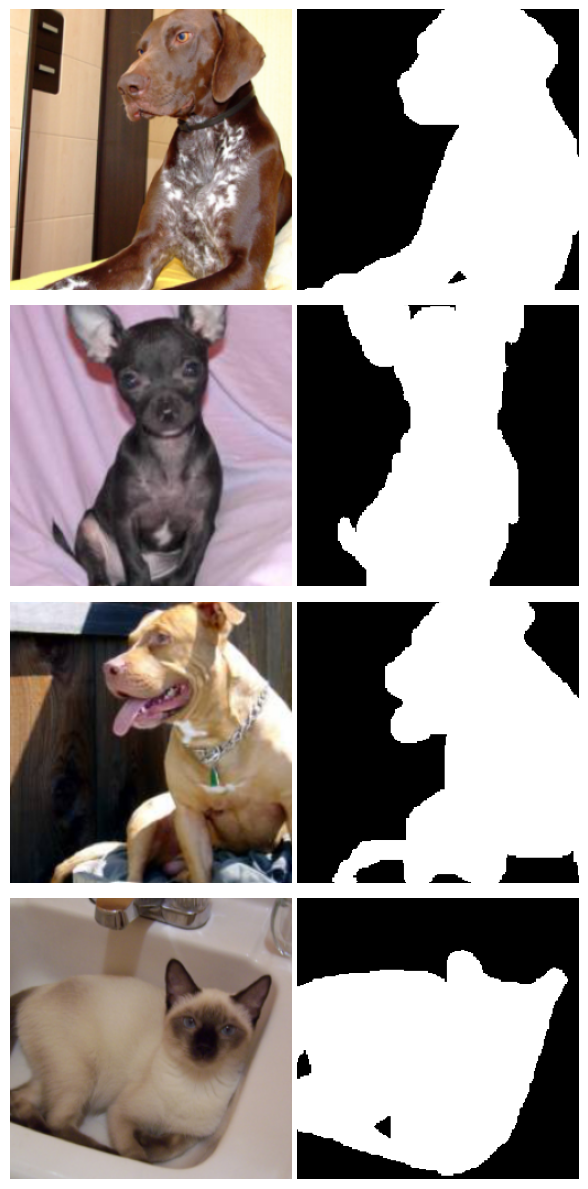

In [47]:
# 3. Define the transform factory
from torchvision.transforms import RandomResizedCrop
from segmentation_models_pytorch.datasets import OxfordPetDataset
IMG_SIZE = 224

class AugPetDataset(OxfordPetDataset):
    def __len__(self):
        return len(self.filenames)*4

    def __getitem__(self, idx):
        filename = self.filenames[idx//4]
        mode=idx%4
        image_path = os.path.join(self.images_directory, filename + ".jpg")
        mask_path = os.path.join(self.masks_directory, filename + ".png")

        image = np.array(Image.open(image_path).convert("RGB"))

        trimap = np.array(Image.open(mask_path))
        mask = self._preprocess_mask(trimap)

        sample = dict(image=image, mask=mask, trimap=trimap)
        sample['mode']=mode
        if self.transform is not None:
            sample = self.transform(**sample)

        # resize images
        image = np.array(
            Image.fromarray(sample["image"]).resize((256, 256), Image.BILINEAR)
        )
        mask = np.array(
            Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST)
        )
        trimap = np.array(
            Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST)
        )

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        sample["trimap"] = np.expand_dims(trimap, 0)

        return sample

def seg_transform(augment=False):
    def fn(image, mask, trimap):
        # PIL-ify
        img_pil = Image.fromarray(image)
        m_pil   = Image.fromarray(mask)

        # spatial aug
            


        if augment and random.random()<0.5:
            i,j,h,w = RandomResizedCrop.get_params(
                img_pil, scale=(0.8,1.0), ratio=(3/4,4/3))
            img_pil = TF.resized_crop(img_pil, i,j,h,w, (IMG_SIZE,IMG_SIZE))
            m_pil   = TF.resized_crop(m_pil,   i,j,h,w, (IMG_SIZE,IMG_SIZE),
                                      interpolation=Image.NEAREST)
            if random.random()<0.5:
                img_pil, m_pil = TF.hflip(img_pil), TF.hflip(m_pil)
        else:
            # print('1',img_pil.size)
            img_pil = TF.resize(img_pil, 256)
            # print('2',img_pil.size)
            m_pil   = TF.resize(m_pil,   256, interpolation=Image.NEAREST)
            img_pil = TF.center_crop(img_pil, IMG_SIZE)
            # print('3',img_pil.size)
            m_pil   = TF.center_crop(m_pil,   IMG_SIZE)

        # image → tensor → normalize
        # t_img = TF.to_tensor(img_pil)
        # print(t_img.mean(),t_img.std())
        # t_img = (TF.normalize(t_img, mean, std)*255).numpy().astype(np.uint8)
        # t_img=np.transpose(t_img,[1,2,0])
        
        t_img = TF.to_tensor(img_pil)
        # # t_img = (TF.normalize(t_img, mean, std)*255).numpy().astype(np.uint8)
        t_img=np.transpose((t_img*255).numpy().astype(np.uint8),[1,2,0])
        # t_img = TF.to_pil_image(t_img)
        # print('4',t_img.size())
        # t_img = TF.normalize(img_pil, mean, std)

        # mask → binarize (only label=1 is pet) → tensor
        mask_np = np.array(m_pil)
        t_mask  = (mask_np == 1).astype(np.uint8)
        # torch.from_numpy((mask_np == 1).astype(np.int64))
        # print('5',t_img.numpy().astype(int).shape)

        # we must return all three keys
        return {"image":t_img, "mask":t_mask, "trimap":trimap.astype(np.uint8)}
    return fn

def aug_transform(augment=False):
    def fn(image, mask, trimap, mode):
        # print(mode)
        # PIL-ify
        img_pil = Image.fromarray(image)
        m_pil   = Image.fromarray(mask)

        # spatial aug
        if mode==0 or mode==1:
            img_pil = TF.resize(img_pil, 256)
            # print('2',img_pil.size)
            m_pil   = TF.resize(m_pil,   256, interpolation=Image.NEAREST)
            img_pil = TF.center_crop(img_pil, IMG_SIZE)
            # print('3',img_pil.size)
            m_pil   = TF.center_crop(m_pil,   IMG_SIZE)
            if mode ==1:
                img_pil, m_pil = TF.hflip(img_pil), TF.hflip(m_pil)

            
        elif mode==2 or mode==3:
            i,j,h,w = RandomResizedCrop.get_params(
                img_pil, scale=(0.8,1.0), ratio=(3/4,4/3))
            img_pil = TF.resized_crop(img_pil, i,j,h,w, (IMG_SIZE,IMG_SIZE))
            m_pil   = TF.resized_crop(m_pil,   i,j,h,w, (IMG_SIZE,IMG_SIZE),
                                      interpolation=Image.NEAREST)
            if mode==3:
                img_pil, m_pil = TF.hflip(img_pil), TF.hflip(m_pil)
            


        # if augment and random.random()<0.5:
        #     i,j,h,w = RandomResizedCrop.get_params(
        #         img_pil, scale=(0.8,1.0), ratio=(3/4,4/3))
        #     img_pil = TF.resized_crop(img_pil, i,j,h,w, (IMG_SIZE,IMG_SIZE))
        #     m_pil   = TF.resized_crop(m_pil,   i,j,h,w, (IMG_SIZE,IMG_SIZE),
        #                               interpolation=Image.NEAREST)
        #     if random.random()<0.5:
        #         img_pil, m_pil = TF.hflip(img_pil), TF.hflip(m_pil)
        # else:
        #     # print('1',img_pil.size)
        #     img_pil = TF.resize(img_pil, 256)
        #     # print('2',img_pil.size)
        #     m_pil   = TF.resize(m_pil,   256, interpolation=Image.NEAREST)
        #     img_pil = TF.center_crop(img_pil, IMG_SIZE)
        #     # print('3',img_pil.size)
        #     m_pil   = TF.center_crop(m_pil,   IMG_SIZE)

        # image → tensor → normalize
        # t_img = TF.to_tensor(img_pil)
        # print(t_img.mean(),t_img.std())
        # t_img = (TF.normalize(t_img, mean, std)*255).numpy().astype(np.uint8)
        # t_img=np.transpose(t_img,[1,2,0])
        
        t_img = TF.to_tensor(img_pil)
        # # t_img = (TF.normalize(t_img, mean, std)*255).numpy().astype(np.uint8)
        t_img=np.transpose((t_img*255).numpy().astype(np.uint8),[1,2,0])
        # t_img = TF.to_pil_image(t_img)
        # print('4',t_img.size())
        # t_img = TF.normalize(img_pil, mean, std)

        # mask → binarize (only label=1 is pet) → tensor
        mask_np = np.array(m_pil)
        t_mask  = (mask_np == 1).astype(np.uint8)
        # torch.from_numpy((mask_np == 1).astype(np.int64))
        # print('5',t_img.numpy().astype(int).shape)

        # we must return all three keys
        return {"image":t_img, "mask":t_mask, "trimap":trimap.astype(np.uint8)}
    return fn

# 4. Build datasets & loaders
train_ds     = SimpleOxfordPetDataset(data_dir, mode="train", transform=seg_transform(False))
# train_aug_ds = SimpleOxfordPetDataset(data_dir, mode="train", transform=seg_transform(True))
train_aug_ds = AugPetDataset(data_dir, mode="train", transform=aug_transform(True))
val_ds       = SimpleOxfordPetDataset(data_dir, mode="valid", transform=seg_transform(False))
test_ds      = SimpleOxfordPetDataset(data_dir, mode="test",  transform=seg_transform(False))

loader_args = dict(batch_size=4, num_workers=2, pin_memory=False)
train_loader     = DataLoader(train_ds,     shuffle=True,  **loader_args)
train_aug_loader = DataLoader(train_aug_ds, shuffle=True,  **loader_args)
val_loader       = DataLoader(val_ds,       shuffle=False, **loader_args)
test_loader      = DataLoader(test_ds,      shuffle=False, **loader_args)

# 5. Visualize a batch
# batch  = next(iter(train_loader))
batch  = next(iter(train_loader))
imgs   = batch["image"]   # shape [B,3,224,224]
masks  = batch["mask"]    # shape [B,224,224]

# un‐normalize for display
# mn = torch.tensor(mean).view(1,3,1,1)
# sd = torch.tensor(std).view(1,3,1,1)
# imgs_disp= imgs.float()/255 * sd + mn
imgs_disp= imgs.float()/255

fig, axes = plt.subplots(4, 2, figsize=(6,12))
for i in range(4):
    # print(imgs_disp[i])
    # print(imgs_disp[i])
    axes[i,0].imshow(((imgs_disp[i])).permute(1,2,0).cpu().numpy())
    axes[i,0].axis('off')
    axes[i,1].imshow(masks[i][0].cpu().numpy(), cmap='gray')
    axes[i,1].axis('off')
plt.tight_layout()
plt.show()



In [ ]:
## b. Build a model and train.

pre=True,aug=False,ep1 tl=0.2850 vl=0.2308 va=0.9015
pre=True,aug=False,ep2 tl=0.2161 vl=0.1901 va=0.9242
pre=True,aug=False,ep3 tl=0.1863 vl=0.1853 va=0.9261
pre=True,aug=False,ep4 tl=0.1724 vl=0.1832 va=0.9285
pre=True,aug=False,ep5 tl=0.1572 vl=0.1787 va=0.9293
pre=True,aug=False,ep6 tl=0.1508 vl=0.1793 va=0.9300
pre=True,aug=False,ep7 tl=0.1441 vl=0.1782 va=0.9303
pre=True,aug=False,ep8 tl=0.1407 vl=0.1770 va=0.9315
pre=True,aug=False,ep9 tl=0.1369 vl=0.1775 va=0.9307
pre=True,aug=False,ep10 tl=0.1364 vl=0.1756 va=0.9311
pre=True,aug=True,ep1 tl=0.2280 vl=0.1753 va=0.9295
pre=True,aug=True,ep2 tl=0.1640 vl=0.1667 va=0.9330
pre=True,aug=True,ep3 tl=0.1443 vl=0.1602 va=0.9367
pre=True,aug=True,ep4 tl=0.1339 vl=0.1555 va=0.9395
pre=True,aug=True,ep5 tl=0.1257 vl=0.1534 va=0.9405
pre=True,aug=True,ep6 tl=0.1213 vl=0.1546 va=0.9396
pre=True,aug=True,ep7 tl=0.1185 vl=0.1490 va=0.9414
pre=True,aug=True,ep8 tl=0.1166 vl=0.1512 va=0.9412
pre=True,aug=True,ep9 tl=0.1152 vl=0.1518 va=0.9418
p

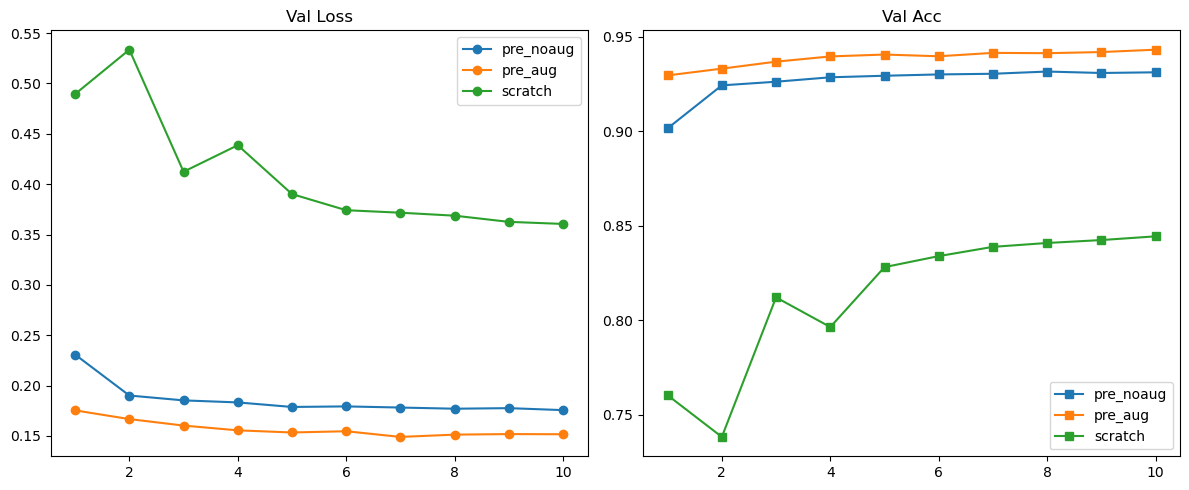

pre_noaug test acc: 0.9353
pre_aug test acc: 0.9450
scratch test acc: 0.8489


In [49]:
import os, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import functional as TF
class FCNResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        self.encoder = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool,
            backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4
        )
        self.classifier = nn.Conv2d(512, 2, kernel_size=1)
    def forward(self, x):
        H,W = x.shape[2:]
        f   = self.encoder(x)
        out = self.classifier(f)
        return F.interpolate(out, size=(H,W), mode='bilinear', align_corners=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:6")


# ------------ c Train/Eval loops ------------
def train_epoch(mdl, loader, opt, crit):
    mdl.train(); tot=0
    for sample in loader:
        x,y=(sample['image'].float()/255).to(device),sample['mask'][:,0].long().to(device)
        # x,y=x.to(device), y.to(device)
        opt.zero_grad()
        l = crit(mdl(x), y)
        l.backward(); opt.step()
        tot += l.item()*x.size(0)
    return tot/len(loader.dataset)

def eval_epoch(mdl, loader, crit):
    mdl.eval(); tot=0; corr=0; px=0
    with torch.no_grad():
        for sample in loader:
            x,y=(sample['image'].float()/255).to(device),sample['mask'][:,0].long().to(device)
            # x,y=x.to(device), y.to(device)
            out=mdl(x)
            tot += crit(out,y).item()*x.size(0)
            pred = out.argmax(1)
            corr+= (pred==y).sum().item()
            px += y.numel()
            # print(pred.shape,y.shape)
    return tot/len(loader.dataset), corr/px

def run(pre, aug):
    mdl = FCNResNet18(pre).to(device)
    opt = optim.SGD(mdl.parameters(), lr=1e-3, momentum=0.9)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
    crit= nn.CrossEntropyLoss()
    stats={'train_loss':[],'val_loss':[],'val_acc':[]}
    ld = train_aug_loader if aug else train_loader
    for e in range(1,11):
        tl = train_epoch(mdl, ld, opt, crit)
        vl,va = eval_epoch(mdl, val_loader, crit)
        sch.step()
        stats['train_loss'].append(tl)
        stats['val_loss'].append(vl)
        stats['val_acc'].append(va)
        print(f"pre={pre},aug={aug},ep{e} tl={tl:.4f} vl={vl:.4f} va={va:.4f}")
    return mdl, stats

runs = {
    'pre_noaug': run(True,  False),
    'pre_aug':   run(True,  True),
    'scratch':   run(False, False),
}

# plot val metrics
epochs = list(range(1,11))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for k,(_,s) in runs.items():
    plt.plot(epochs, s['val_loss'], marker='o', label=k)
plt.title("Val Loss"); plt.legend()

plt.subplot(1,2,2)
for k,(_,s) in runs.items():
    plt.plot(epochs, s['val_acc'], marker='s', label=k)
plt.title("Val Acc"); plt.legend()
plt.tight_layout(); plt.show()

# test accuracies
for k,(m,_) in runs.items():
    _,acc = eval_epoch(m, test_loader, nn.CrossEntropyLoss())
    print(f"{k} test acc: {acc:.4f}")



## d. Visualize some test samples. 

torch.Size([4, 256, 256]) torch.Size([4, 256, 256])
0.9348487854003906


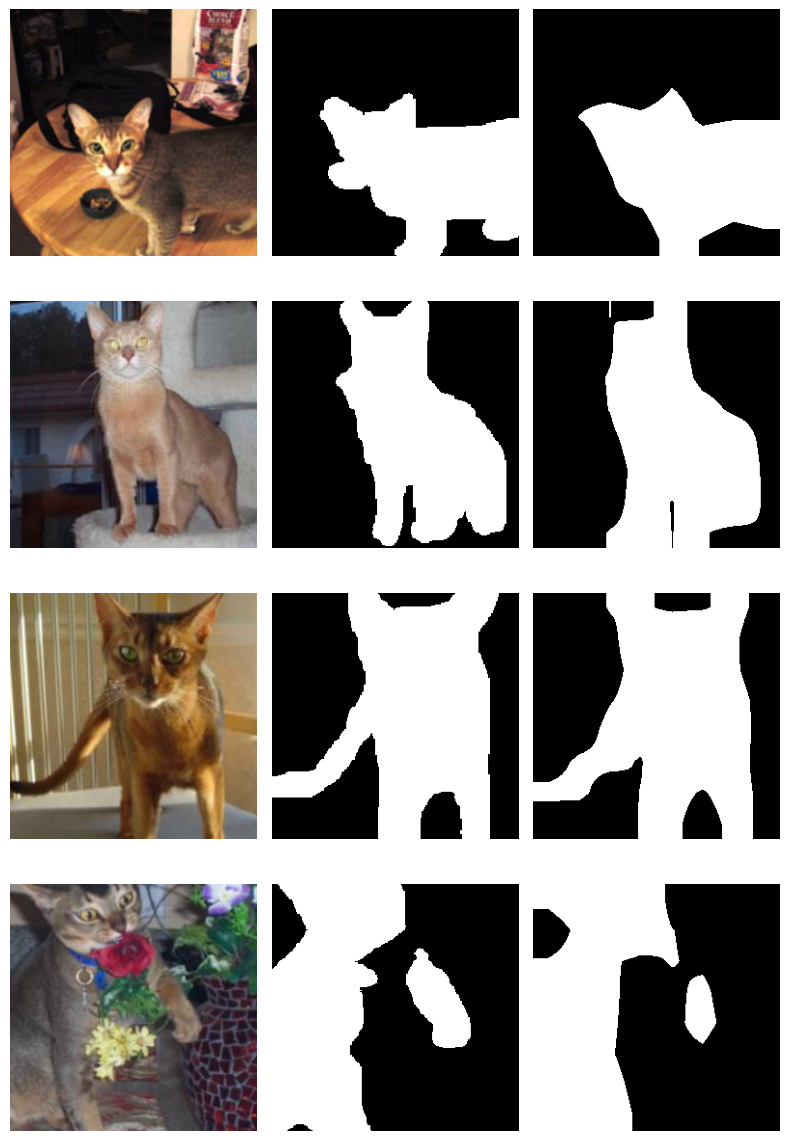

In [ ]:
mdl = runs['pre_aug'][0]
sample = next(iter(test_loader))

imgs,masks=(sample['image'].float()/255).to(device), sample['mask'][:,0].long().to(device)
corr=0
px=0
with torch.no_grad():
    preds = mdl(imgs).argmax(1)
    corr+= (preds==masks).sum().item()
    px += masks.numel()
    print(preds.shape,masks.shape)
print(corr/px)
    

# imgs_vis = imgs*sd.to(device)+mn.to(device)
imgs_vis=imgs.float()
plt.figure(figsize=(8,12))
for i in range(4):
    plt.subplot(4,3,3*i+1); plt.imshow(imgs_vis[i].permute(1,2,0).cpu()); plt.axis('off')
    plt.subplot(4,3,3*i+2); plt.imshow(masks[i].cpu(), cmap='gray');      plt.axis('off')
    plt.subplot(4,3,3*i+3); plt.imshow(preds[i].cpu(), cmap='gray');      plt.axis('off')
plt.tight_layout(); plt.show()